# MyoPS 2020 Challenge

End-to-end, multi-channel, focal loss, all classes, cropped

In [23]:
!pip install fastai2

In [2]:
!pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

In [3]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

In [76]:
import nibabel as nib
from tqdm.notebook import tqdm

### fastai U-Net on these static images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [6]:
np.random.seed(42)
ids = np.arange(101,151)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,10))
ids

array([[114, 140, 131, 146, 118, 149, 127, 126, 133, 120],
       [113, 105, 138, 109, 104, 107, 142, 147, 148, 116],
       [110, 117, 125, 135, 132, 101, 145, 128, 134, 106],
       [130, 112, 137, 102, 122, 103, 144, 136, 124, 141],
       [111, 123, 119, 150, 121, 108, 143, 115, 129, 139]])

Use cropping instead of resizing

In [7]:
myopsDlsCV2 = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
    get_items=get_image_files,
    splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in ids[2]),
    get_y=lambda o: str(o).replace("images","masks"),
    item_tfms=CropPad(256),
    batch_tfms=aug_transforms(max_rotate=90)).dataloaders(f'{path}/images',num_workers=8,batch_size=16)

**Attention!** The cropped version can have masks close to the edge and zooming or rotation can lead to additional masks at the edge because of padding in reflection mode

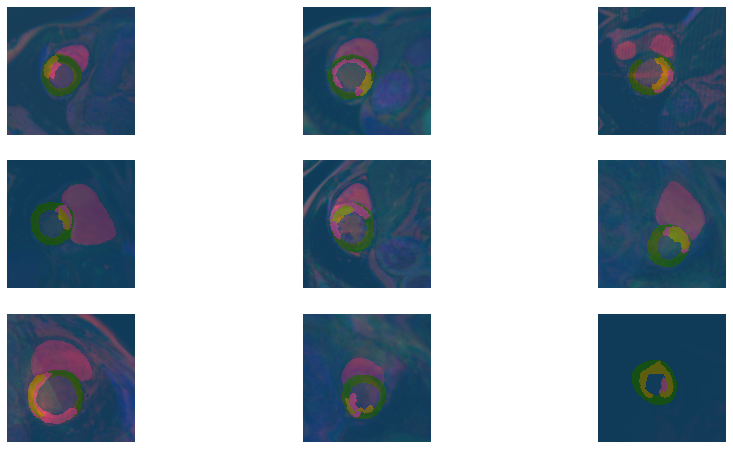

In [8]:
myopsDlsCV2.show_batch(figsize=(15,8))

In [9]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [10]:
monaiFocal = FocalLoss(weight=torch.Tensor([.1,.1,.1,.1,.3,.3]),reduction='mean')
def myFocal(input, target):
  return monaiFocal(input, target.unsqueeze(1))

In [11]:
learn = unet_learner(
  myopsDlsCV2,
  resnet34,
  loss_func=myFocal,
  metrics=[foreground_acc, *dices]
)

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.044007,0.028133,0.478790,0.627545,0.384430,0.390974,0.069765,0.259211,01:47
1,0.030388,0.012517,0.557703,0.716798,0.486364,0.551262,0.142290,0.313969,00:58
2,0.021407,0.010617,0.606330,0.825947,0.446162,0.643325,0.179295,0.316878,00:58
3,0.016559,0.009547,0.670442,0.810208,0.513441,0.676347,0.204326,0.376673,00:58
4,0.013943,0.008928,0.712547,0.829844,0.668258,0.716503,0.126735,0.412575,00:58
5,0.011974,0.008265,0.723334,0.798926,0.682192,0.734220,0.188346,0.448737,00:58
6,0.010418,0.007701,0.708598,0.809296,0.677582,0.720642,0.207105,0.436437,00:58
7,0.009285,0.007511,0.741221,0.847643,0.660595,0.717062,0.248716,0.503438,00:58
8,0.008478,0.007247,0.765233,0.813461,0.709445,0.709124,0.249141,0.480533,00:58
9,0.007806,0.008030,0.758779,0.851293,0.728519,0.737933,0.259820,0.474235,00:58


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.005809,0.007354,0.763696,0.850519,0.713343,0.748554,0.265058,0.503438,01:00
1,0.005777,0.007809,0.748086,0.864670,0.706699,0.735294,0.260963,0.491481,01:00
2,0.005703,0.007849,0.731630,0.825877,0.698434,0.742895,0.259523,0.512605,01:00
3,0.005724,0.007096,0.768284,0.847822,0.692148,0.741554,0.259715,0.512295,01:00
4,0.005732,0.007876,0.761633,0.854788,0.727507,0.754858,0.243895,0.526549,01:00
5,0.005559,0.008048,0.756428,0.845899,0.702920,0.741936,0.252578,0.523437,01:00
6,0.005396,0.007862,0.766163,0.826274,0.706926,0.756943,0.253998,0.485523,01:00
7,0.005268,0.007942,0.768132,0.857353,0.725878,0.747764,0.260972,0.526170,01:00
8,0.005079,0.007393,0.766926,0.832780,0.713923,0.757164,0.249630,0.487356,01:00
9,0.004948,0.007790,0.759292,0.843251,0.725774,0.740860,0.252766,0.488700,01:00


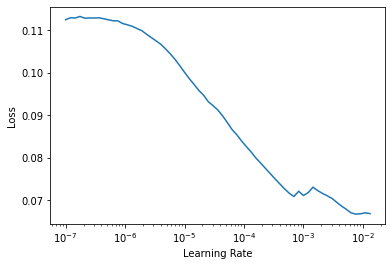

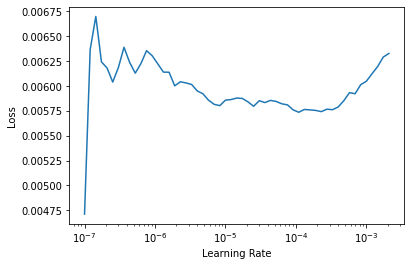

In [12]:
learn = unet_learner(
  myopsDlsCV2,
  resnet34,
  loss_func=myFocal,
  metrics=[foreground_acc, *dices]
)
learn.lr_find()
learn.fit_one_cycle(15,lr_max=1e-3)
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(15,lr_max=1e-4)

In [24]:
learn.path = Path(path).parent

In [25]:
# For some reason export does not work -> use save instead
learn.save('allClasses_multiChannel_crop256_focal3_cv2_15_15.pkl')

# Predictions for original images

In [72]:
outdir = f'{path}/../pred/allClasses_multiChannel_crop256_focal3_cv2_15_15'
os.makedirs(outdir, exist_ok=True)

In [81]:
mapping = torch.LongTensor([0, 500, 200, 600, 1220, 2221])

for id in tqdm(np.arange(101,126)):
  origs = sorted(glob.glob(f"{path}/images/{id}-orig-*.png"))
  masks = []
  for o in origs:
    image = PILImage.create(o)
    mask = PILMask.create(learn.predict(o)[0].argmax(dim=0).byte()).crop_pad((image.shape[1],image.shape[0]))
    mask = mapping.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
    masks.append(mask.to(torch.int32))
  masks = np.stack(masks,axis=2)
  nifti = nib.load(f'{path}/../train25_myops_gd/myops_training_{id}_gd.nii.gz')
  nifti_pred = nib.Nifti1Image(masks, nifti.affine, nifti.header)
  nib.save(nifti_pred, f'{outdir}/myops_test_{id}_seg.nii.gz')

In [79]:
origs

[]

# Experiments

In [26]:
result = learn.get_preds()

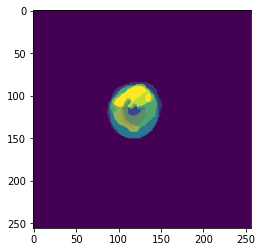

In [27]:
plt.imshow(result[0][0].argmax(dim=0))
plt.imshow(result[1][0], alpha=.5)

In [28]:
origs = glob.glob(f"{path}/images/*orig*")

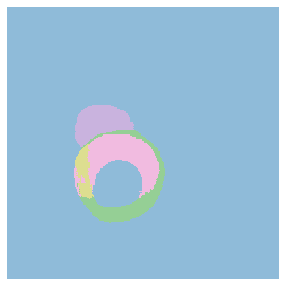

In [29]:
learn.predict(origs[0])[0].argmax(dim=0).show()

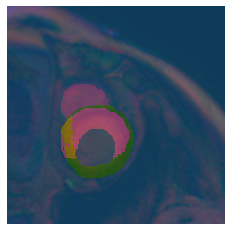

In [30]:
fig,ax = plt.subplots()
PILImage(PILImage.create(origs[0]).crop_pad(256)).show(ax=ax)
learn.predict(origs[0])[0].argmax(dim=0).show(ax=ax)

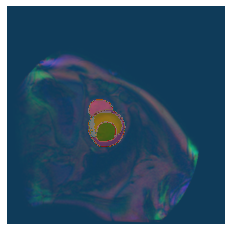

In [31]:
fig,ax = plt.subplots()
image = PILImage.create(origs[0])
image.show(ax=ax)
mask = PILMask(PILMask.create(learn.predict(origs[0])[0].argmax(dim=0).byte()).crop_pad(image.shape))
mask.show(ax=ax)

In [33]:
np.unique(learn.predict(origs[0])[0].argmax(dim=0), return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([58343,  1635,  1523,  1359,  2190,   486]))

In [21]:
np.unique(image2tensor(mask).numpy(),return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([253928,   1635,   1523,   1359,   2190,    486]))

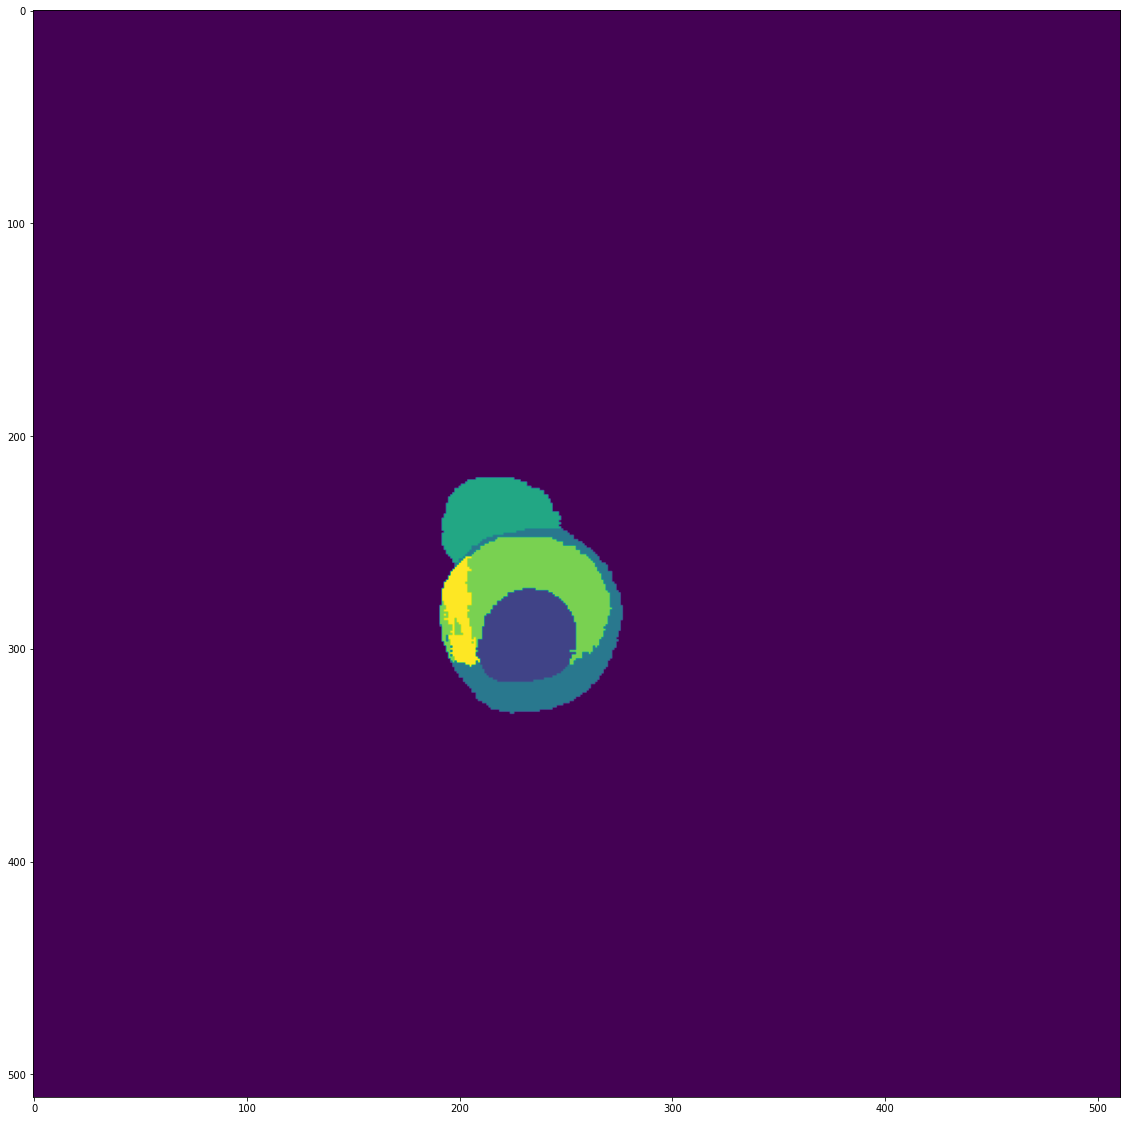

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(image2tensor(mask).numpy()[0])

In [36]:
nifti102 = np.asanyarray(nib.load(f'{path}/../train25_myops_gd/myops_training_102_gd.nii.gz').dataobj)

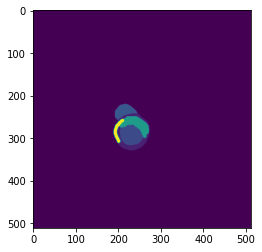

In [37]:
plt.imshow(nifti102[:,:,0])

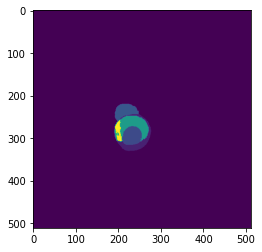

In [41]:
# (LV) blood pool (labelled 500), right ventricular blood pool (600), LV normal myocardium (200), LV myocardial edema (1220), LV myocardial scars (2221)
mapping = torch.LongTensor([0, 500, 200, 600, 1220, 2221])
mask = PILMask.create(learn.predict(origs[0])[0].argmax(dim=0).byte()).crop_pad(image.shape)
mask = mapping.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
plt.imshow(mask)

In [52]:
origs[0]

'/content/drive/My Drive/miccai2020/myops/png/images/102-orig-0.png'

In [51]:
mask.to(torch.int32).numpy().dtype

dtype('int32')

In [55]:
origs = sorted(glob.glob(f"{path}/images/102-orig-*.png"))

In [70]:
masks = []
for o in origs:
  mapping = torch.LongTensor([0, 500, 200, 600, 1220, 2221])
  mask = PILMask.create(learn.predict(o)[0].argmax(dim=0).byte()).crop_pad(image.shape)
  mask = mapping.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
  masks.append(mask.to(torch.int32))
masks = np.stack(masks,axis=2)

In [65]:
masks.shape

(511, 511, 3)

In [62]:
nifti102.shape

(511, 511, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


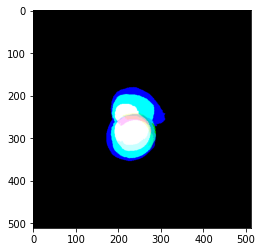

In [66]:
plt.imshow(masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


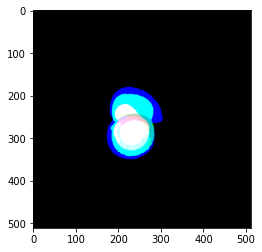

In [67]:
plt.imshow(nifti102)

In [68]:
nifti102_raw = nib.load(f'{path}/../train25_myops_gd/myops_training_102_gd.nii.gz')

In [71]:
nifti102_pred = nib.Nifti1Image(masks, nifti102_raw.affine, nifti102_raw.header)

In [74]:
nib.save(nifti102_pred, f'{outdir}/myops_test_102_seg.nii.gz')